In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
output_dir_4_5_5 ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.5_linear_scale-up_etc/ciff_sam/2021_11_23_17_59_09/count_data/'
output_dir_4_5_6 ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.6_no_x_factor/ciff_sam/2021_11_29_14_01_14/count_data/'

In [3]:
def calculate_wasting_transition_rates(output_dir,
                                      ages, transition, source_state, 
                                      groupby_cols, time_to_response=False):
    wasting_pt = pd.read_csv(output_dir +'wasting_state_person_time.csv').drop(columns='Unnamed: 0')
    wasting_transitions = pd.read_csv(output_dir +'wasting_transition_count.csv').drop(columns='Unnamed: 0')
    transition = (wasting_transitions.loc[(wasting_transitions.age.isin(ages))
                                         & (wasting_transitions.measure==transition)]
                  .groupby(groupby_cols).sum())
    pt = (wasting_pt.loc[(wasting_pt.age.isin(ages))
                       & (wasting_pt.cause==source_state)]
          .groupby(groupby_cols).sum())
    transition_rate = transition / pt
    if time_to_response==True:
        transition_rate = 365 / transition_rate
    transition_rate = (transition_rate.groupby([c for c in groupby_cols if c != 'input_draw'])
                       .describe(percentiles=[0.025,0.975]))['value']
    return transition_rate

In [4]:
ages = ['6-11_months', '12_to_23_months', '2_to_4']

In [5]:
# i1 (MAM to SAM) in 4.5.5 with x-factor
calculate_wasting_transition_rates(output_dir_4_5_5, ages, 
                                   'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count', 
                                   'moderate_acute_malnutrition', 
                                      ['input_draw','scenario'], time_to_response=False)

,count,mean,std,min,2.5%,50%,97.5%,max
scenario,,,,,,,,
baseline,12.0,1.881085,0.166318,1.611623,1.646078,1.905576,2.143461,2.190107
sqlns,12.0,1.893940,0.167979,1.622029,1.656783,1.915445,2.162153,2.210424
wasting_treatment,12.0,1.886841,0.166193,1.616425,1.651128,1.908292,2.150547,2.197140


In [6]:
#i1 (MAM to SAM) in 4.5.6 without x-factor
calculate_wasting_transition_rates(output_dir_4_5_6, ages, 
                                   'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count', 
                                   'moderate_acute_malnutrition', 
                                      ['input_draw','scenario'], time_to_response=False)

,count,mean,std,min,2.5%,50%,97.5%,max
scenario,,,,,,,,
baseline,12.0,1.478817,0.131275,1.265059,1.292181,1.499533,1.691137,1.727720
sqlns,12.0,1.484804,0.131391,1.271335,1.298164,1.505024,1.699267,1.735679
wasting_treatment,12.0,1.481728,0.131269,1.267405,1.294545,1.504089,1.694371,1.730749


i1 incidence rate from MAM to SAM is higher in the x-factor run than in the run without the x-factor. This could be driving the overestimation of SAM and underestimation of MAM

So let's check what it looks like stratified by the x-factor exposure

In [7]:
x_factor_rr = 3.16
x_factor_exposure = 0.5
x_factor_paf = (((x_factor_rr * x_factor_exposure + 1 * (1 - x_factor_exposure)) - 1) 
                / (x_factor_rr * x_factor_exposure + 1 * (1 - x_factor_exposure)))
x_factor_paf

0.5192307692307693

In [8]:
# what unexposed to x-factor transition rate should be based on i1 from 4.5.6 (without x-factor)
1.478817 * (1 - x_factor_paf)

0.7109697115384614

In [9]:
# what exposed to x-factor transition rate should be based on i1 from 4.5.6 (without x-factor)
1.478817 * (1 - x_factor_paf) * x_factor_rr

2.246664288461538

In [10]:
# i1 (MAM to SAM) in 4.5.5 with x-factor by x-factor exposure
calculate_wasting_transition_rates(output_dir_4_5_5, ages, 
                                   'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count', 
                                   'moderate_acute_malnutrition', 
                                      ['input_draw','scenario','x_factor'], time_to_response=False)


# these look pretty close to what they should be...

count      mean       std       min      2.5%  \
scenario          x_factor                                                  
baseline          cat1       12.0  2.263399  0.200477  1.939847  1.980745   
                  cat2       12.0  0.696571  0.060926  0.600500  0.610332   
sqlns             cat1       12.0  2.273005  0.202231  1.946346  1.987781   
                  cat2       12.0  0.697375  0.061679  0.598481  0.608116   
wasting_treatment cat1       12.0  2.268927  0.200079  1.944074  1.985067   
                  cat2       12.0  0.697917  0.061723  0.600144  0.610025   

                                 50%     97.5%       max  
scenario          x_factor                                
baseline          cat1      2.290835  2.581116  2.642229  
                  cat2      0.704319  0.797671  0.809668  
sqlns             cat1      2.296712  2.595219  2.657701  
                  cat2      0.705079  0.798211  0.809414  
wasting_treatment cat1      2.292664  2.586029  2.646818  
                  cat2      0.707057  0.799459  0.811886

In [11]:
# but exposure-weighted incidence does not match overall incidence from 4.5.5 (1.88)
# instead it matches what we would expect at 1.47 from 4.5.6
# what is going on here??

2.263399 * 0.5 + 0.696571 * 0.5

1.479985

In [12]:
# seems like we have too many x-factor exposed simulants transitioning from mam to sam then...
# so let's check x-factor exposure status

In [13]:
wasting_pt = pd.read_csv(output_dir_4_5_5 +'wasting_state_person_time.csv').drop(columns='Unnamed: 0')
wasting_transitions = pd.read_csv(output_dir_4_5_5 +'wasting_transition_count.csv').drop(columns='Unnamed: 0')

In [14]:
# let's check x-factor exposure 
a = wasting_pt.groupby(['input_draw','scenario','x_factor']).sum()#.groupby(['scenario','cause','x_factor']).mean()
b = wasting_pt.groupby(['input_draw','scenario']).sum()
(a/b).groupby(['scenario','x_factor']).describe(percentiles=[0.025,0.975])['value']
# looks to be ~ 50% overall

count      mean       std       min      2.5%  \
scenario          x_factor                                                  
baseline          cat1       12.0  0.500014  0.001291  0.498228  0.498308   
                  cat2       12.0  0.499986  0.001291  0.496922  0.497556   
sqlns             cat1       12.0  0.500046  0.001294  0.498268  0.498346   
                  cat2       12.0  0.499954  0.001294  0.496883  0.497520   
wasting_treatment cat1       12.0  0.500033  0.001291  0.498254  0.498331   
                  cat2       12.0  0.499967  0.001291  0.496910  0.497541   

                                 50%     97.5%       max  
scenario          x_factor                                
baseline          cat1      0.500015  0.502444  0.503078  
                  cat2      0.499985  0.501692  0.501772  
sqlns             cat1      0.500046  0.502480  0.503117  
                  cat2      0.499954  0.501654  0.501732  
wasting_treatment cat1      0.500031  0.502459  0.503090  
                  cat2      0.499969  0.501669  0.501746

In [29]:
# now let's check by wasting state
a = wasting_pt.loc[wasting_pt.x_factor=='cat1'].groupby(['input_draw','scenario','cause','x_factor']).sum()
b = wasting_pt.groupby(['input_draw','scenario','cause']).sum()
(a/b).groupby(['scenario','cause','x_factor']).describe(percentiles=[0.025,0.975])['value']

count      mean  \
scenario          cause                        x_factor                    
baseline          mild_child_wasting           cat1       12.0  0.540665   
                  moderate_acute_malnutrition  cat1       12.0  0.786749   
                  severe_acute_malnutrition    cat1       12.0  0.929364   
                  susceptible_to_child_wasting cat1       12.0  0.445799   
sqlns             mild_child_wasting           cat1       12.0  0.543880   
                  moderate_acute_malnutrition  cat1       12.0  0.794043   
                  severe_acute_malnutrition    cat1       12.0  0.933202   
                  susceptible_to_child_wasting cat1       12.0  0.449654   
wasting_treatment mild_child_wasting           cat1       12.0  0.542704   
                  moderate_acute_malnutrition  cat1       12.0  0.789862   
                  severe_acute_malnutrition    cat1       12.0  0.931195   
                  susceptible_to_child_wasting cat1       12.0  0.448208   

                                                              std       min  \
scenario          cause                        x_factor                       
baseline          mild_child_wasting           cat1      0.001524  0.537736   
                  moderate_acute_malnutrition  cat1      0.002943  0.782575   
                  severe_acute_malnutrition    cat1      0.001918  0.926198   
                  susceptible_to_child_wasting cat1      0.001264  0.443889   
sqlns             mild_child_wasting           cat1      0.001545  0.540541   
                  moderate_acute_malnutrition  cat1      0.002732  0.789916   
                  severe_acute_malnutrition    cat1      0.002052  0.930354   
                  susceptible_to_child_wasting cat1      0.001218  0.448134   
wasting_treatment mild_child_wasting           cat1      0.001448  0.539833   
                  moderate_acute_malnutrition  cat1      0.002817  0.785909   
                  severe_acute_malnutrition    cat1      0.002041  0.928392   
                  susceptible_to_child_wasting cat1      0.001222  0.446385   

                                                             2.5%       50%  \
scenario          cause                        x_factor                       
baseline          mild_child_wasting           cat1      0.538058  0.540886   
                  moderate_acute_malnutrition  cat1      0.783038  0.785743   
                  severe_acute_malnutrition    cat1      0.926486  0.929607   
                  susceptible_to_child_wasting cat1      0.444036  0.445750   
sqlns             mild_child_wasting           cat1      0.541126  0.543886   
                  moderate_acute_malnutrition  cat1      0.790268  0.793387   
                  severe_acute_malnutrition    cat1      0.930385  0.933567   
                  susceptible_to_child_wasting cat1      0.448139  0.449543   
wasting_treatment mild_child_wasting           cat1      0.540310  0.542645   
                  moderate_acute_malnutrition  cat1      0.786304  0.788880   
                  severe_acute_malnutrition    cat1      0.928484  0.931752   
                  susceptible_to_child_wasting cat1      0.446492  0.448171   

                                                            97.5%       max  
scenario          cause                        x_factor                      
baseline          mild_child_wasting           cat1      0.543250  0.543614  
                  moderate_acute_malnutrition  cat1      0.791300  0.791379  
                  severe_acute_malnutrition    cat1      0.932568  0.933050  
                  susceptible_to_child_wasting cat1      0.448021  0.448372  
sqlns             mild_child_wasting           cat1      0.546408  0.546683  
                  moderate_acute_malnutrition  cat1      0.798319  0.798485  
                  severe_acute_malnutrition    cat1      0.936711  0.937349  
                  susceptible_to_child_wasting cat1      0.451915  0.452229 

Text(0.5, 1.0, 'X-factor exposure by wasting state')

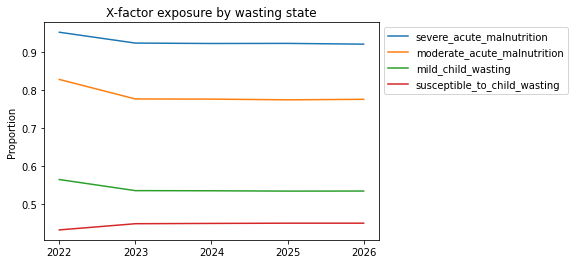

In [40]:
a = wasting_pt.groupby(['input_draw','scenario','cause','year','x_factor']).sum()#.groupby(['scenario','cause','x_factor']).mean()
b = wasting_pt.groupby(['input_draw','scenario','cause','year']).sum()
p = (a/b).groupby(['scenario','cause','year','x_factor']).describe(percentiles=[0.025,0.975])['value'].reset_index()
for cause in ['severe_acute_malnutrition',
             'moderate_acute_malnutrition',
             'mild_child_wasting',
             'susceptible_to_child_wasting']:
    plt.plot(p.loc[(p.scenario=='baseline')&(p.x_factor=='cat1')&(p.cause==cause)]['year'],
            p.loc[(p.scenario=='baseline')&(p.x_factor=='cat1')&(p.cause==cause)]['mean'],
            label=cause)
plt.legend(bbox_to_anchor=[1,1])
plt.xticks(p.year.unique())
plt.ylabel('Proportion')
plt.title('X-factor exposure by wasting state')

In [44]:
p.loc[(p.x_factor=='cat1')&(p.cause=='susceptible_to_child_wasting')]

,scenario,cause,year,x_factor,count,mean,std,min,2.5%,50%,97.5%,max
30,baseline,susceptible_to_child_wasting,2022,cat1,12.0,0.431920,0.001084,0.430037,0.430203,0.432193,0.433174,0.433181
32,baseline,susceptible_to_child_wasting,2023,cat1,12.0,0.448272,0.001496,0.445627,0.445781,0.448337,0.450807,0.451256
34,baseline,susceptible_to_child_wasting,2024,cat1,12.0,0.449050,0.001488,0.446795,0.446994,0.449128,0.451692,0.452147
36,baseline,susceptible_to_child_wasting,2025,cat1,12.0,0.449662,0.001644,0.447493,0.447503,0.449536,0.452867,0.453659
38,baseline,susceptible_to_child_wasting,2026,cat1,12.0,0.449643,0.001675,0.447035,0.447333,0.449789,0.452717,0.453341
70,sqlns,susceptible_to_child_wasting,2022,cat1,12.0,0.431920,0.001084,0.430037,0.430203,0.432193,0.433174,0.433181
72,sqlns,susceptible_to_child_wasting,2023,cat1,12.0,0.449195,0.001434,0.446738,0.446875,0.449141,0.451623,0.452000
74,sqlns,susceptible_to_child_wasting,2024,cat1,12.0,0.452689,0.001403,0.450932,0.450954,0.452569,0.455224,0.455585
76,sqlns,susceptible_to_child_wasting,2025,cat1,12.0,0.455916,0.001745,0.453320,0.453482,0.456075,0.459149,0.459877
78,sqlns,susceptible_to_child_wasting,2026,cat1,12.0,0.457541,0.001843,0.454370,0.454667,0.457235,0.460768,0.461345


In [42]:
p.loc[(p.x_factor=='cat1')&(p.cause=='mild_child_wasting')]

,scenario,cause,year,x_factor,count,mean,std,min,2.5%,50%,97.5%,max
0,baseline,mild_child_wasting,2022,cat1,12.0,0.564765,0.001358,0.562384,0.562460,0.564830,0.566537,0.566668
2,baseline,mild_child_wasting,2023,cat1,12.0,0.535507,0.001092,0.533739,0.533853,0.535502,0.537069,0.537079
4,baseline,mild_child_wasting,2024,cat1,12.0,0.535135,0.001715,0.531576,0.531840,0.535074,0.537416,0.537812
6,baseline,mild_child_wasting,2025,cat1,12.0,0.534236,0.002530,0.529965,0.530245,0.534286,0.538406,0.538634
8,baseline,mild_child_wasting,2026,cat1,12.0,0.534406,0.002490,0.531512,0.531647,0.533725,0.539566,0.540517
40,sqlns,mild_child_wasting,2022,cat1,12.0,0.564765,0.001358,0.562384,0.562460,0.564830,0.566537,0.566668
42,sqlns,mild_child_wasting,2023,cat1,12.0,0.536677,0.001102,0.535142,0.535166,0.536531,0.538300,0.538301
44,sqlns,mild_child_wasting,2024,cat1,12.0,0.538526,0.001791,0.534443,0.534960,0.538722,0.540807,0.541009
46,sqlns,mild_child_wasting,2025,cat1,12.0,0.539589,0.002513,0.535164,0.535604,0.539856,0.543608,0.543651
48,sqlns,mild_child_wasting,2026,cat1,12.0,0.540712,0.002712,0.536537,0.536903,0.540222,0.545815,0.546648


Text(0.5, 1.0, 'X-factor exposure by wasting state')

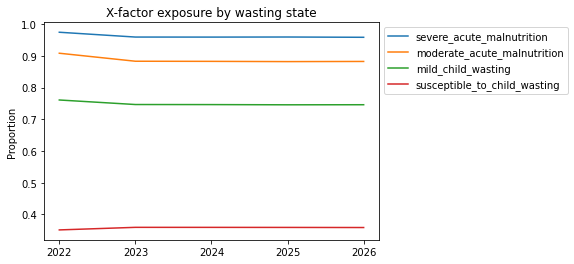

In [30]:
a = wasting_pt.groupby(['input_draw','scenario','cause','age','year','x_factor']).sum()#.groupby(['scenario','cause','x_factor']).mean()
b = wasting_pt.groupby(['input_draw','scenario','cause','age','year']).sum()
p = (a/b).groupby(['scenario','cause','age','year','x_factor']).describe(percentiles=[0.025,0.975])['value'].reset_index()
for cause in ['severe_acute_malnutrition',
             'moderate_acute_malnutrition',
             'mild_child_wasting',
             'susceptible_to_child_wasting']:
    plt.plot(p.loc[(p.scenario=='baseline')&(p.x_factor=='cat1')&(p.cause==cause)]['year'],
            p.loc[(p.scenario=='baseline')&(p.x_factor=='cat1')&(p.cause==cause)]['mean'],
            label=cause)
plt.legend(bbox_to_anchor=[1,1])
plt.xticks(p.year.unique())
plt.ylabel('Proportion')
plt.title('X-factor exposure by wasting state')

In [38]:
#a = wasting_pt.groupby(['input_draw','scenario','cause','age','year','x_factor']).sum()#.groupby(['scenario','cause','x_factor']).mean()
#b = wasting_pt.groupby(['input_draw','scenario','cause','age','year']).sum()
#p = (a/b).groupby(['scenario','cause','age','year','x_factor']).describe(percentiles=[0.025,0.975])['value'].reset_index()
p.loc[(p.scenario=='baseline')&(p.age=='2_to_4')&(p.x_factor=='cat1')&(p.year==2025)]

,scenario,cause,age,year,x_factor,count,mean,std,min,2.5%,50%,97.5%,max
26,baseline,mild_child_wasting,2_to_4,2025,cat1,12.0,0.478624,0.002653,0.474668,0.475001,0.478472,0.483110,0.483244
86,baseline,moderate_acute_malnutrition,2_to_4,2025,cat1,12.0,0.729512,0.004807,0.722913,0.723261,0.728391,0.738102,0.739111
146,baseline,severe_acute_malnutrition,2_to_4,2025,cat1,12.0,0.896172,0.004308,0.889089,0.889730,0.896511,0.902628,0.903217
206,baseline,susceptible_to_child_wasting,2_to_4,2025,cat1,12.0,0.478209,0.001165,0.476989,0.477009,0.478009,0.480558,0.481086


In [35]:
p.age.unique()

array(['1-5_months', '12_to_23_months', '2_to_4', '6-11_months',
       'early_neonatal', 'late_neonatal'], dtype=object)

In [18]:
# so let's test some different exposures/PAFs...

In [19]:
def print_incidence_rates(x_factor_exposure_for_paf_calculation, 
                   x_factor_exposure_for_overall_rate_calculation,
                   overall_transition_value_without_x_factor):
    x_factor_rr = 3.16
    x_factor_paf = (((x_factor_rr * x_factor_exposure_for_paf_calculation + 1 * (1 - x_factor_exposure_for_paf_calculation)) - 1) 
                    / (x_factor_rr * x_factor_exposure_for_paf_calculation + 1 * (1 - x_factor_exposure_for_paf_calculation)))
    unexposed_rate = overall_transition_value_without_x_factor * (1 - x_factor_paf)
    exposed_rate = unexposed_rate * x_factor_rr
    overall_rate = unexposed_rate * (1 - x_factor_exposure_for_overall_rate_calculation) + exposed_rate * x_factor_exposure_for_overall_rate_calculation
    print('unexposed_rate: ',unexposed_rate,'\nexposed_rate: ',exposed_rate,'\noverall_rate: ',overall_rate)

In [20]:
print_incidence_rates(x_factor_exposure_for_paf_calculation=0.5, 
               x_factor_exposure_for_overall_rate_calculation=0.5,
              overall_transition_value_without_x_factor=1.478817)

unexposed_rate:  0.7109697115384614 
exposed_rate:  2.246664288461538 
overall_rate:  1.4788169999999998


In [21]:
print_incidence_rates(x_factor_exposure_for_paf_calculation=0.5, 
               x_factor_exposure_for_overall_rate_calculation=0.77,
              overall_transition_value_without_x_factor=1.478817)

unexposed_rate:  0.7109697115384614 
exposed_rate:  2.246664288461538 
overall_rate:  1.8934545357692305


In [22]:
print_incidence_rates(x_factor_exposure_for_paf_calculation=0.77, 
               x_factor_exposure_for_overall_rate_calculation=0.77,
              overall_transition_value_without_x_factor=1.478817)

unexposed_rate:  0.55527823670772 
exposed_rate:  1.7546792279963954 
overall_rate:  1.478817


# look at mild to mam transition too for consistency

In [23]:
# i2 (mild to MAM) in 4.5.5 with x-factor
calculate_wasting_transition_rates(output_dir_4_5_5, ages, 
                                   'mild_child_wasting_to_moderate_acute_malnutrition_event_count', 
                                   'mild_child_wasting', 
                                      ['input_draw','scenario'], time_to_response=False)

,count,mean,std,min,2.5%,50%,97.5%,max
scenario,,,,,,,,
baseline,12.0,2.275872,0.061230,2.153593,2.160756,2.285441,2.354328,2.354587
sqlns,12.0,2.098197,0.052997,1.981086,1.991580,2.120699,2.144345,2.144975
wasting_treatment,12.0,2.283400,0.060755,2.161666,2.168929,2.292037,2.360283,2.360592


In [24]:
# i2 (mild to MAM) in 4.5.6 without x-factor
calculate_wasting_transition_rates(output_dir_4_5_6, ages, 
                                   'mild_child_wasting_to_moderate_acute_malnutrition_event_count', 
                                   'mild_child_wasting', 
                                      ['input_draw','scenario'], time_to_response=False)

,count,mean,std,min,2.5%,50%,97.5%,max
scenario,,,,,,,,
baseline,12.0,2.303764,0.062578,2.175886,2.186362,2.306274,2.383482,2.384150
sqlns,12.0,2.114371,0.053588,1.994793,2.007124,2.137583,2.164380,2.166067
wasting_treatment,12.0,2.304367,0.062428,2.176659,2.187041,2.306845,2.383756,2.384776


In [25]:
# i2 (mild to MAM) in 4.5.5 with x-factor
calculate_wasting_transition_rates(output_dir_4_5_5, ages, 
                                   'mild_child_wasting_to_moderate_acute_malnutrition_event_count', 
                                   'mild_child_wasting', 
                                      ['input_draw','scenario','x_factor'], time_to_response=False)

count      mean       std       min      2.5%  \
scenario          x_factor                                                  
baseline          cat1       12.0  3.501611  0.093468  3.308654  3.321715   
                  cat2       12.0  1.106286  0.030013  1.047732  1.052163   
sqlns             cat1       12.0  3.214266  0.083252  3.029249  3.047006   
                  cat2       12.0  1.014440  0.025445  0.958660  0.964321   
wasting_treatment cat1       12.0  3.503163  0.093480  3.310540  3.323202   
                  cat2       12.0  1.106623  0.029994  1.048007  1.052401   

                                 50%     97.5%       max  
scenario          x_factor                                
baseline          cat1      3.513056  3.620910  3.621660  
                  cat2      1.106123  1.145240  1.146727  
sqlns             cat1      3.252355  3.284248  3.285309  
                  cat2      1.022157  1.039790  1.040039  
wasting_treatment cat1      3.513490  3.621671  3.622941  
                  cat2      1.106970  1.145438  1.146793

In [26]:
print_incidence_rates(x_factor_exposure_for_paf_calculation=0.5, 
               x_factor_exposure_for_overall_rate_calculation=0.5,
              overall_transition_value_without_x_factor=2.303764)

unexposed_rate:  1.107578846153846 
exposed_rate:  3.4999491538461536 
overall_rate:  2.3037639999999997


In [27]:
print_incidence_rates(x_factor_exposure_for_paf_calculation=0.5, 
               x_factor_exposure_for_overall_rate_calculation=0.54,
              overall_transition_value_without_x_factor=2.303764)

unexposed_rate:  1.107578846153846 
exposed_rate:  3.4999491538461536 
overall_rate:  2.3994588123076923


In [28]:
print_incidence_rates(x_factor_exposure_for_paf_calculation=0.54, 
               x_factor_exposure_for_overall_rate_calculation=0.54,
              overall_transition_value_without_x_factor=2.303764)

unexposed_rate:  1.0634065731166913 
exposed_rate:  3.3603647710487445 
overall_rate:  2.303764
